In [3]:
## from https://wyhtsai.github.io/pyaos-wks/docs/A6_tropical_waves.html 

In [5]:



%load_ext autoreload
%autoreload 2

from scipy.interpolate import griddata
import numpy as np
from scipy.ndimage import gaussian_filter #從 scipy.ndimage 導入 gaussian_filter
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4 as nc
import h5py
#from numba import jit,njit,prange
from numpy import linalg
from time import sleep
from tqdm import tqdm, trange
#import torch, torch.linalg
from tqdm import tqdm
import shutil
from time import gmtime, strftime
from scipy.fft import *
import matplotlib
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
import xarray as xr
from scipy.interpolate import *

import funcs as fff
import PyAOS as pyaos 

# for latex style 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from os import environ

environ['OMP_NUM_THREADS'] = '1'

from scipy.spatial import distance_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
case_str = 'nicam'
case_str_n = 'NICAM \n'

In [41]:
print(data1['time'][0])
print(data1['time'][-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2020-03-01T01:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-03-01T01:30:00
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    axis:           T
<xarray.DataArray 'time' ()> Size: 8B
array('2021-02-28T22:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2021-02-28T22:30:00
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    axis:           T


In [7]:
#data_ori = xr.open_dataset('/work/DATA/Satellite/CERES/SYN1deg_daily.nc')
#data_ori['lw_toa'] = data_ori['lw_up'][:,0,:]
#olr = data_ori['lw_up'][:,0,:]

#ata = xr.open_mfdataset(path+'lw_toa_daily.nc')

path = '/work/kuoray/Master/jphack2/'
figpath = '/home/kuoray/Master/Japan_hack/figs/'
data1 = xr.open_dataset(path+'sa_lwu_toa.nc')

olr = data1['rlut'][:,0,:,:]


lats, latn = -15, 15 
olr = olr.sel(lat=slice(lats,latn))

In [8]:
# lat south, lat north 


olrDayClm = olr.groupby('time.dayofyear').mean('time')
olrDayClm_sm = pyaos.smthClmDay(olrDayClm, 3) 
# time: al least one year 
# olra = olr.sel(time=slice('2017-01-01','2018-12-31')).groupby('time.dayofyear') - olrDayClm_sm 
olra = olr.groupby('time.dayofyear') - olrDayClm_sm 

olra

<xarray.DataArray 'rlut' (time: 2920, lat: 121, lon: 1440)> Size: 2GB
array([[[  7.7953186 ,   4.651947  ,   4.5476685 , ...,   6.7163696 ,
           4.6885376 ,   7.310211  ],
        [  8.3272705 ,   8.2526245 ,   8.857361  , ...,   6.967102  ,
           8.049316  ,   7.5507812 ],
        [  9.27771   ,  10.43161   ,  10.58963   , ...,   8.171417  ,
           8.104706  ,   9.5703125 ],
        ...,
        [ -9.23645   , -11.869141  , -12.273041  , ..., -15.842651  ,
         -13.874298  , -11.688629  ],
        [-10.0173645 , -12.770233  , -12.9841    , ..., -15.312286  ,
         -13.108368  , -15.191925  ],
        [-18.913269  , -16.745667  , -20.956451  , ..., -16.482208  ,
         -15.067749  , -17.736969  ]],

       [[  6.1951904 ,   2.4200745 ,   1.0783081 , ...,   3.3319397 ,
           3.4773254 ,   2.7207031 ],
        [  4.6591187 ,   4.0787964 ,   3.8457642 , ...,   3.0462952 ,
           3.4975586 ,   5.152832  ],
        [  7.093384  ,   8.054932  ,   9.437897  , ...,   4.6701965 ,
           6.4518433 ,   8.33786   ],
...
           7.1978455 ,   6.0383606 ],
        [  6.0724487 ,   4.8884583 ,   5.443695  , ...,   4.193512  ,
           4.8412476 ,   1.0268555 ],
        [ -2.0734253 ,  -0.58428955,   2.3391113 , ...,   8.405579  ,
           6.991974  ,   2.505188  ]],

       [[ -1.72995   ,  -4.615814  ,  -6.248352  , ...,   0.7515869 ,
           1.0820312 ,   1.2337341 ],
        [ -4.747528  ,  -7.916565  ,  -2.289093  , ...,  -0.8673401 ,
           0.6220093 ,   1.4091187 ],
        [ -7.8583374 ,  -0.5915222 ,  -2.407837  , ...,   2.5925903 ,
          -0.35339355,   0.82870483],
        ...,
        [  0.52493286,   2.8656921 ,   1.5415039 , ...,   2.251831  ,
           1.8571167 ,  -1.9050903 ],
        [  3.636139  ,   4.7805176 ,   2.0209045 , ...,   3.221222  ,
           2.370636  ,   2.2752686 ],
        [  1.7004395 ,   3.252716  ,   1.0388794 , ...,   6.574005  ,
           4.126587  ,   1.9387817 ]]],
      shape=(2920, 121, 1440), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2020-03-01T01:30:00 ... 2021-02-28T...
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * lat        (lat) float64 968B -15.0 -14.75 -14.5 -14.25 ... 14.5 14.75 15.0
    lev        (time) float64 23kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dayofyear  (time) int64 23kB 61 61 61 61 61 61 61 ... 59 59 59 59 59 59 59

In [10]:
'''
Create empty DataArrays for each wave band, 
then define : wavenumber, 
              period, 
              equivalent 
for each band. 
Note that the equivalent depth should only be specified for 
wave types that have theoretical solutions with dispersion relations 
(e.g., Kelvin, Eq. Rossby, Mixed Rby-Gravity); 

for other wave types, set this parameter as mis.
'''


# wave filter
mis = -999.
obsPerDay = 8
lat = olra.lat.values

lf     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mjo    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
er     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
kelvin = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mt     = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))
mrg    = xr.DataArray(dims=['time','lat','lon'],coords=dict(time=olra.time,lat=olra.lat,lon=olra.lon))

# lf parameters 
lf_filter="above 120 days"
lf_wavenumber=np.array([mis,mis],dtype='f')
lf_period=np.array([120,mis],dtype='f')
lf_depth=np.array([mis*-1.,mis],dtype='f')

# mjo parameters 
mjo_filter="Kiladis et al. (2005 JAS) for 20-100"
mjo_wavenumber=np.array([1,5],dtype='f')
mjo_period=np.array([30,96],dtype='f')
mjo_depth=np.array([mis,mis],dtype='f')
    
# er parameters 
er_filter="Kiladis et al. (2009 Rev. Geophys.)"
er_wavenumber=np.array([-10,-1],dtype='f')
er_period=np.array([9.7,48],dtype='f')
er_depth=np.array([8,90],dtype='f')

# kw parameters
kelvin_filter="Straub & Kiladis (2002) to 20 days"
kelvin_wavenumber=np.array([1,14],dtype='f')
kelvin_period=np.array([2.5,30],dtype='f')
kelvin_depth=np.array([8,90],dtype='f')

# mt parameters
mt_filter="MRG-TD type wave filter (Frank & Roundy 2006)"
mt_wavenumber=np.array([-14,0],dtype='f')
mt_period=np.array([2.5,10],dtype='f')
mt_depth=np.array([mis,mis],dtype='f')

# mrg parameters
mrg_filter="MRG-TD type wave filter"
mrg_wavenumber=np.array([-10,-1],dtype='f')
mrg_period=np.array([3,9.6],dtype='f')
mrg_depth=np.array([8,90],dtype='f')

In [11]:
for y in lat: 
    print('latitude: ' + str(y))
    #################################################
    # Filter
    #################################################
    #lf
    
    lf.loc[:,y,:] = pyaos.kf_filter(olra.loc[:,y,:].values,
                                    obsPerDay,
                                    lf_period[0],lf_period[1],
                                    lf_wavenumber[0],lf_wavenumber[1],
                                    lf_depth[0],lf_depth[1],"none")
    
    
    #mjo
    mjo.loc[:,y,:] = pyaos.kf_filter(olra.loc[:,y,:].values,
                                    obsPerDay,
                                    mjo_period[0],mjo_period[1],
                                    mjo_wavenumber[0],mjo_wavenumber[1],
                                    mjo_depth[0],mjo_depth[1],"none")
                
    #er 
    er.loc[:,y,:] = pyaos.kf_filter(olra.loc[:,y,:].values,
                                   obsPerDay,
                                   er_period[0],er_period[1],
                                   er_wavenumber[0],er_wavenumber[1],
                                   er_depth[0],er_depth[1],"er")
                
    ## kw
    kelvin.loc[:,y,:] = pyaos.kf_filter(olra.loc[:,y,:].values,
                                       obsPerDay,
                                       kelvin_period[0],kelvin_period[1],
                                       kelvin_wavenumber[0],kelvin_wavenumber[1],
                                       kelvin_depth[0],kelvin_depth[1],"kelvin")
                
    # mt 
    mt.loc[:,y,:] =  pyaos.kf_filter(olra.loc[:,y,:].values,
                                       obsPerDay,
                                       mt_period[0],mt_period[1],
                                       mt_wavenumber[0],mt_wavenumber[1],
                                       mt_depth[0],mt_depth[1],"none")
                        
    # mrg 
    mrg.loc[:,y,:] =  pyaos.kf_filter(olra.loc[:,y,:].values,
                                        obsPerDay,
                                        mrg_period[0],mrg_period[1],
                                        mrg_wavenumber[0],mrg_wavenumber[1],
                                        mrg_depth[0],mrg_depth[1],"mrg")

latitude: -15.0
latitude: -14.75
latitude: -14.5
latitude: -14.25
latitude: -14.0
latitude: -13.75
latitude: -13.5
latitude: -13.25
latitude: -13.0
latitude: -12.75
latitude: -12.5
latitude: -12.25
latitude: -12.0
latitude: -11.75
latitude: -11.5
latitude: -11.25
latitude: -11.0
latitude: -10.75
latitude: -10.5
latitude: -10.25
latitude: -10.0
latitude: -9.75
latitude: -9.5
latitude: -9.25
latitude: -9.0
latitude: -8.75
latitude: -8.5
latitude: -8.25
latitude: -8.0
latitude: -7.75
latitude: -7.5
latitude: -7.25
latitude: -7.0
latitude: -6.75
latitude: -6.5
latitude: -6.25
latitude: -6.0
latitude: -5.75
latitude: -5.5
latitude: -5.25
latitude: -5.0
latitude: -4.75
latitude: -4.5
latitude: -4.25
latitude: -4.0
latitude: -3.75
latitude: -3.5
latitude: -3.25
latitude: -3.0
latitude: -2.75
latitude: -2.5
latitude: -2.25
latitude: -2.0
latitude: -1.75
latitude: -1.5
latitude: -1.25
latitude: -1.0
latitude: -0.75
latitude: -0.5
latitude: -0.25
latitude: 0.0
latitude: 0.25
latitude: 0.5
latitu

In [16]:
##### GRAPＨ ############## 
import pandas as pd
from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cmaps

time1 = '2017-12-01'
time2 = '2018-02-28'
lon1 = 39 
lon2 = 181
lats = 5
latn = 15

'''
olrh     =   olra.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
er_hovm  =     er.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mjo_hovm =    mjo.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
mt_hovm  =     mt.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
kw_hovm  = kelvin.sel(time=slice(time1,time2),lat=slice(lats,latn),lon=slice(lon1,lon2)).mean(axis=1)
'''

olrh     =   olra.sel(lon=slice(lon1,lon2)).mean(axis=1)
er_hovm  =     er.sel(lon=slice(lon1,lon2)).mean(axis=1)
mjo_hovm =    mjo.sel(lon=slice(lon1,lon2)).mean(axis=1)
mt_hovm  =     mt.sel(lon=slice(lon1,lon2)).mean(axis=1)
kw_hovm  = kelvin.sel(lon=slice(lon1,lon2)).mean(axis=1)




/home/kuoray/miniconda3/envs/torch310/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


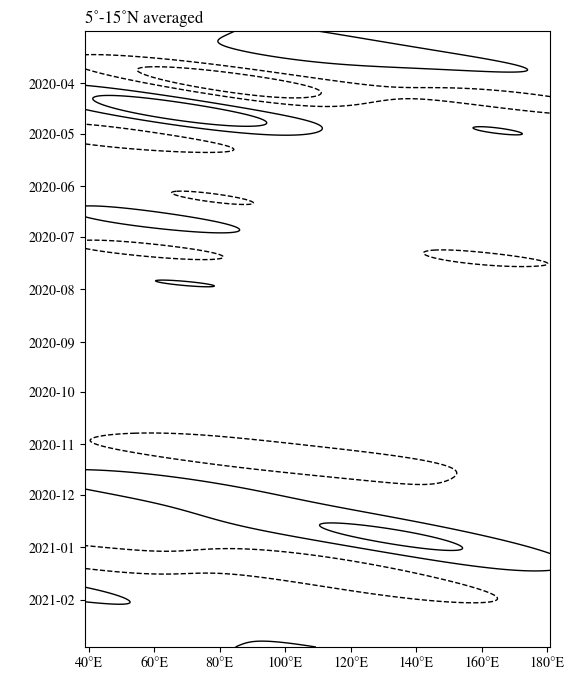

In [17]:

# Plot settings
plt.figure(figsize=(6, 8))     
ax = plt.axes() 
ax.set_xticks(np.arange(40,200,20))
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)

clevs = [-72,-60,-48,-36,-24,-12,12,24,36,48,60,72]
plt.title("OLR anomaly", loc='left')
#hovm_plot = olrh.plot.contourf(x="lon", y="time",
#                               ax=ax, 
#                               levels=clevs,                    
#                               cmap='Blues',  
#                               yincrease=False,                 # y axis be increasing from top to bottom
#                               add_colorbar=True, 
#                               extend='both',                   # color bar 兩端向外延伸
#                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' ', 'ticks':clevs})
#kw_plot = kw_hovm.plot.contour(x='lon',y='time', ax=ax,
#                               levels=[-30,-15,15,30], 
#                              colors='blue',linewidths=1,
#                              yincrease=False) 

#mt_plot = mt_hovm.plot.contour(x='lon',y='time', ax=ax,
#                               levels=[-30,-15,15,30], 
#                               colors='navy',linewidths=1,
#                               yincrease=False) 

mjo_plot = mjo_hovm.plot.contour(x='lon',y='time', ax=ax,
                                 levels=[-30,-20,-10,10,20,30], 
                                 colors='black',linewidths=1,
                                 yincrease=False)

#er_plot  = er_hovm.plot.contour(x='lon',y='time', ax=ax,
#                                levels=[-30,-20,-10,10,20,30], 
#                                colors='red',linewidths=1,
#                                yincrease=False)

ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title(' ')
ax.set_title('5˚-15˚N averaged', loc='left')



plt.show()


In [18]:
olrh

<xarray.DataArray 'rlut' (time: 2920, lon: 569)> Size: 7MB
array([[-12.818797 , -12.956251 , -13.836377 , ..., -12.275174 ,
         -8.89477  ,  -8.107317 ],
       [-10.0831   ,  -8.279383 ,  -7.7764955, ..., -11.742321 ,
        -10.1602125,  -9.669515 ],
       [ -2.4949515,  -1.411983 ,   1.4182111, ..., -12.729841 ,
        -11.067766 , -10.618747 ],
       ...,
       [ 34.667152 ,  34.868797 ,  35.53458  , ..., -10.022378 ,
        -10.985262 ,  -9.07535  ],
       [ 32.222443 ,  32.506493 ,  32.66259  , ..., -12.134558 ,
        -15.046062 , -12.738746 ],
       [ 28.823164 ,  29.428003 ,  29.29029  , ...,   3.330288 ,
          4.58531  ,   3.454937 ]], shape=(2920, 569), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 23kB 2020-03-01T01:30:00 ... 2021-02-28T...
  * lon        (lon) float64 5kB 39.0 39.25 39.5 39.75 ... 180.5 180.8 181.0
    lev        (time) float64 23kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dayofyear  (time) int64 23kB 61 61 61 61 61 61 61 ... 59 59 59 59 59 59 59

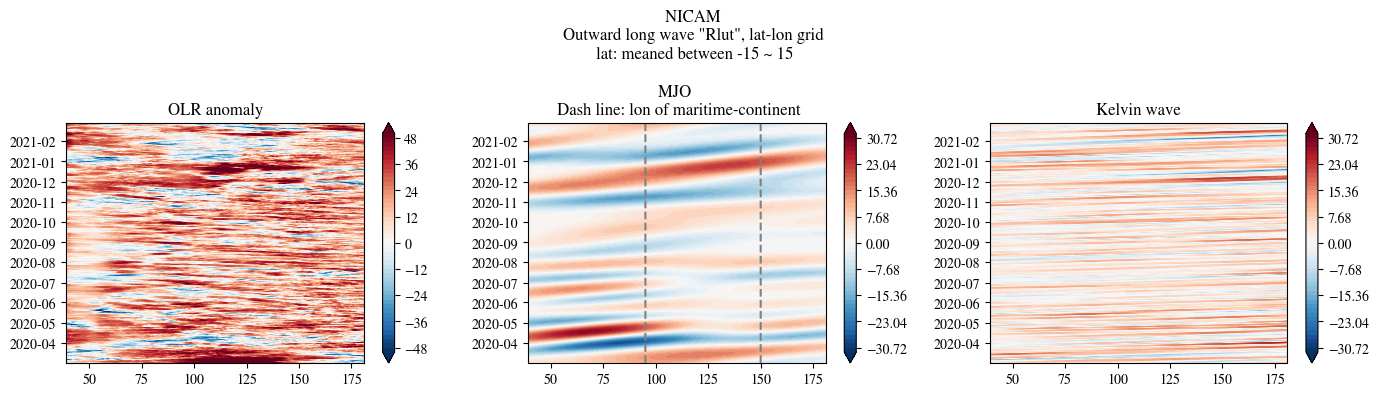

In [82]:
# "Rlut", lat-lon data  
# lat: -15 -- 15 

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

lon = olrh['lon'] 
time = olrh['time']
im  = ax[0].contourf(lon,time,olrh,cmap='RdBu_r',
                     levels = np.linspace(-50,50,51), extend='both'
                        )
cbar = fig.colorbar(im, ax=ax[0], orientation='vertical')
ax[0].set_title('OLR anomaly') 


im  = ax[1].contourf(lon,time,mjo_hovm,cmap='RdBu_r',
                     levels = np.linspace(-32,32,51), extend='both'
                        )
cbar = fig.colorbar(im, ax=ax[1], orientation='vertical')
ax[1].set_title('MJO \n Dash line: lon of maritime-continent')
ax[1].plot(95*np.ones(len(time)),time,'--',color='grey')
ax[1].plot(150*np.ones(len(time)),time,'--',color='grey')

im  = ax[2].contourf(lon,time,kw_hovm,cmap='RdBu_r',
                     levels = np.linspace(-32,32,51), extend='both'
                        )
cbar = fig.colorbar(im, ax=ax[2], orientation='vertical')
ax[2].set_title('Kelvin wave')


plt.suptitle(case_str_n+'Outward long wave "Rlut", lat-lon grid \n lat: meaned between -15 ~ 15 ')
plt.tight_layout() 

plt.savefig(figpath + case_str + 'hovmoller_eq_waves.png',dpi=300)




In [20]:
import numpy as np
from sklearn.decomposition import PCA

data_pca = kelvin.to_numpy()

# assume data shape = (time, lon, lat)
time_len, lon_len, lat_len = data_pca.shape
data_pca_2d = data_pca.reshape(time_len, lon_len * lat_len)

# optionally: remove mean across time
temp_mean = data_pca_2d.mean(axis=0)
data_anom = ( data_pca_2d  - temp_mean ) / data_pca_2d.std(axis=0)


In [21]:
n_modes = 40
pca = PCA(n_components=n_modes)
PCs = pca.fit_transform(data_anom)         # shape: (time, n_modes)
EOFs_flat = pca.components_ 



In [22]:
print(pca.explained_variance_ratio_ )
print(np.sum(pca.explained_variance_ratio_ ))

[0.05245428 0.05017926 0.03624677 0.03393463 0.03125423 0.03014026
 0.02688668 0.02668173 0.02197558 0.02119856 0.0187026  0.01833628
 0.01784436 0.01724049 0.01585071 0.01551028 0.01447847 0.01424856
 0.01336783 0.0131978  0.01294747 0.01284598 0.01156734 0.01148391
 0.01064412 0.01057746 0.01035047 0.01023379 0.00969005 0.00944523
 0.00933582 0.00892999 0.00860905 0.00854355 0.00800331 0.00793015
 0.00762987 0.00735996 0.00709548 0.00700724]
0.6799595778581724


In [23]:
EOFs = EOFs_flat.reshape((n_modes, lon_len, lat_len))  # now each EOF[i] has shape (lon, lat)

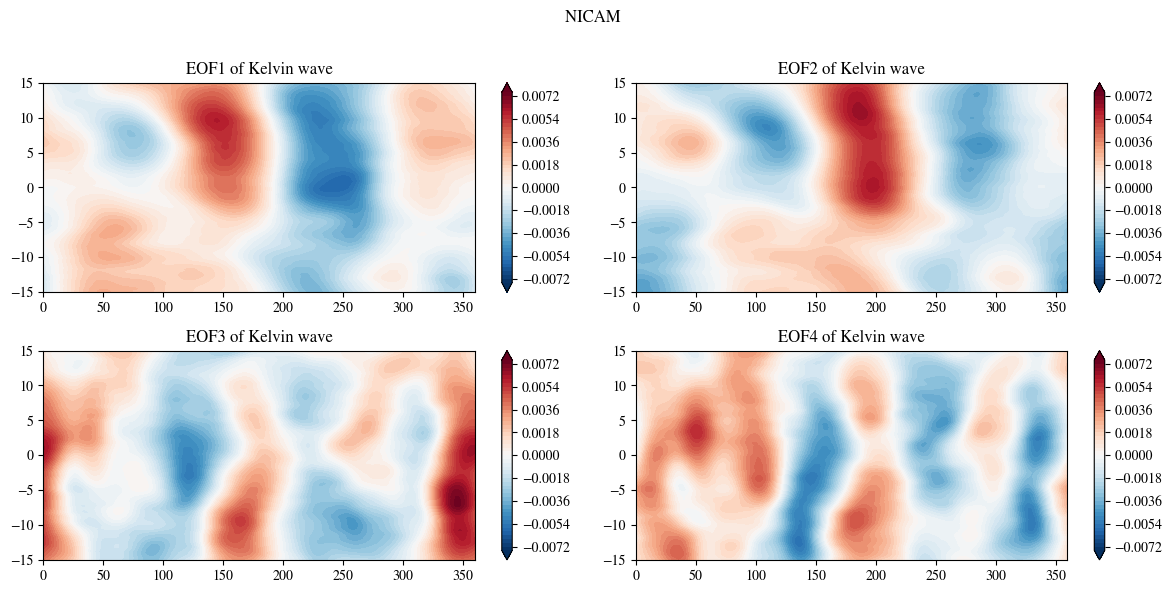

In [83]:
fig, ax = plt.subplots(nrows = 2 , ncols = 2,figsize=(12, 6)) 
lon = kelvin['lon'] 
lat = kelvin['lat']
time = kelvin['time']

for i in range(2): 
    for j in range(2): 
        im  = ax[i,j].contourf(lon,lat,EOFs[i*2+j],cmap='RdBu_r',
                             levels = np.linspace(-0.0075,0.0075,51), extend='both'
                                )
        cbar = fig.colorbar(im, ax=ax[i,j], orientation='vertical')
        ax[i,j].set_title('EOF'+str(i*2+j+1) + ' of Kelvin wave') 
plt.suptitle(case_str_n)
plt.tight_layout()
plt.savefig(figpath + case_str + 'EOF_spatial.png',dpi=300)

In [25]:
'''
fig, ax = plt.subplots()
std = np.sqrt(PCs[:,0]**2 + PCs[:,1]**2).std()
print(std)

angles = np.arange(0,360,1)*np.pi/36 
rs     = np.ones(360)*std*2 

tmpx = rs*np.cos(angles)
tmpy = rs*np.sin(angles)


fff.plot_kw_phase_space_ax(ax,amp=300,std=2*std)
ax.scatter(tmpx,tmpy)
'''

'\nfig, ax = plt.subplots()\nstd = np.sqrt(PCs[:,0]**2 + PCs[:,1]**2).std()\nprint(std)\n\nangles = np.arange(0,360,1)*np.pi/36 \nrs     = np.ones(360)*std*2 \n\ntmpx = rs*np.cos(angles)\ntmpy = rs*np.sin(angles)\n\n\nfff.plot_kw_phase_space_ax(ax,amp=300,std=2*std)\nax.scatter(tmpx,tmpy)\n'

In [26]:
'''
for i in range(36): 
    fig, ax = plt.subplots(ncols=2,figsize=(12, 3))
    
    temp = tmpx[i]*EOFs[0] + tmpy[i]*EOFs[1] 
    im  = ax[0].contourf(lon,lat,temp,cmap='RdBu_r',
                     levels = np.linspace(-1,1,51), extend='both'
                        )
    cbar = fig.colorbar(im, ax=ax[0], orientation='vertical')
    ax[0].set_title('Reconstructed') 

    std = np.sqrt(PCs[:,0]**2 + PCs[:,1]**2).std()
    print(std)
    
    angles = np.arange(0,360,1)*np.pi/36 
    rs     = np.ones(360)*std*2 
    
    tmpx = rs*np.cos(angles)
    tmpy = rs*np.sin(angles)
    
    
    fff.plot_kw_phase_space_ax(ax[1],amp=300,std=2*std)
    ax[1].scatter(tmpx[i],tmpy[i])

    plt.savefig(figpath + f'{i:03d}' +case_str + 'hovmoller_eq_waves.png',dpi=300)
    plt.show()
'''

"\nfor i in range(36): \n    fig, ax = plt.subplots(ncols=2,figsize=(12, 3))\n    \n    temp = tmpx[i]*EOFs[0] + tmpy[i]*EOFs[1] \n    im  = ax[0].contourf(lon,lat,temp,cmap='RdBu_r',\n                     levels = np.linspace(-1,1,51), extend='both'\n                        )\n    cbar = fig.colorbar(im, ax=ax[0], orientation='vertical')\n    ax[0].set_title('Reconstructed') \n\n    std = np.sqrt(PCs[:,0]**2 + PCs[:,1]**2).std()\n    print(std)\n    \n    angles = np.arange(0,360,1)*np.pi/36 \n    rs     = np.ones(360)*std*2 \n    \n    tmpx = rs*np.cos(angles)\n    tmpy = rs*np.sin(angles)\n    \n    \n    fff.plot_kw_phase_space_ax(ax[1],amp=300,std=2*std)\n    ax[1].scatter(tmpx[i],tmpy[i])\n\n    plt.savefig(figpath + f'{i:03d}' +case_str + 'hovmoller_eq_waves.png',dpi=300)\n    plt.show()\n"

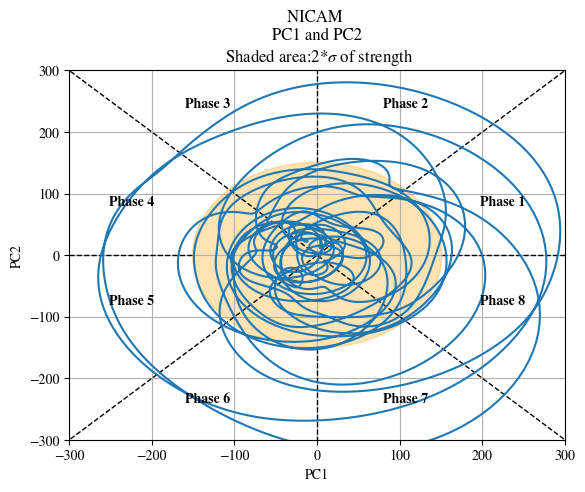

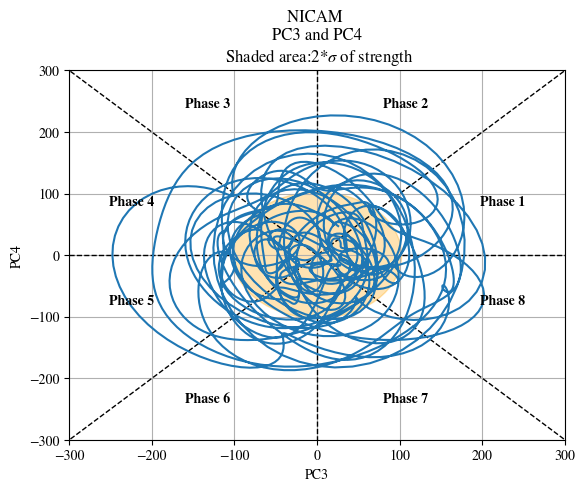

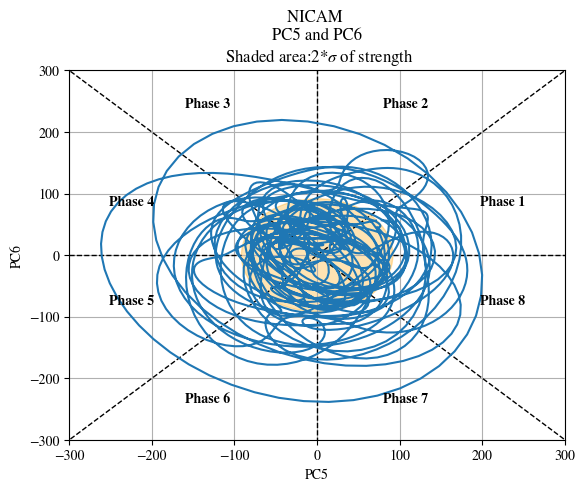

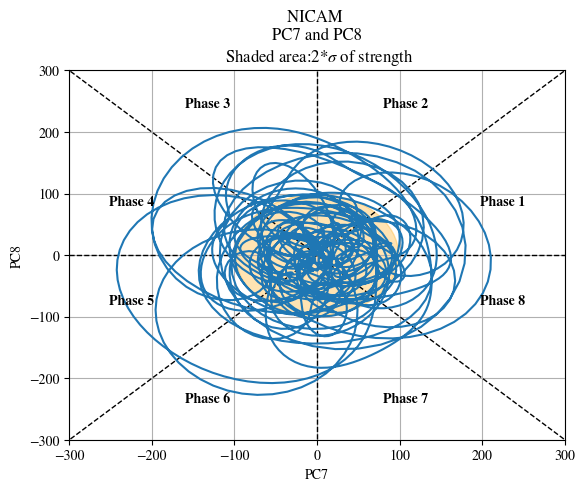

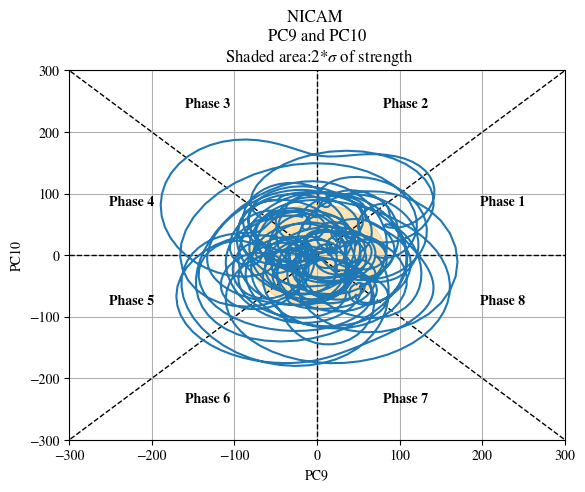

In [84]:
stds = np.zeros(5)
for i in range(5): 
    jj = i*2 
    fig, ax = plt.subplots()
    start = 0 
    end   = -1
    
    PC1 = PCs[:,jj]
    PC2 = PCs[:,jj+1]
    

    std = np.sqrt(PC1**2 + PC2**2).std()
    stds[i] = std
    
    fff.plot_kw_phase_space_ax(ax,amp=300,std=2*std)

    
    ax.plot(PC1[start:end],PC2[start:end])
    ax.set_xlabel('PC'+str(jj+1))
    ax.set_ylabel('PC'+str(jj+2))
    plt.title(case_str_n + 'PC'+str(jj+1)+ ' and ' + 'PC'+str(jj+2) + '\n Shaded area:' +r'2*$\sigma$' + ' of strength'  )
    if i == 1: 
        plt.savefig(figpath + case_str + 'PC1PC2.png',dpi=300)
    elif i==5 : 
        plt.savefig(figpath + case_str + 'PC9PC10.png',dpi=300)
    plt.show()


#ax.scatter(PC1[start], PC2[start], color='red', edgecolors='black', s=150, label='Start')
#ax.scatter(PC1[end-1], PC2[end-1], color='green', edgecolors='black', s=150, label='End')


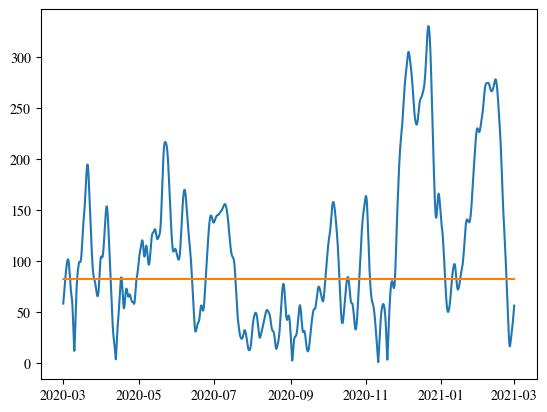

In [51]:
plt.plot(time,np.sqrt(PCs[:,0]**2 + PCs[:,1]**2) )
plt.plot(time,2*std*np.ones(len(time)))

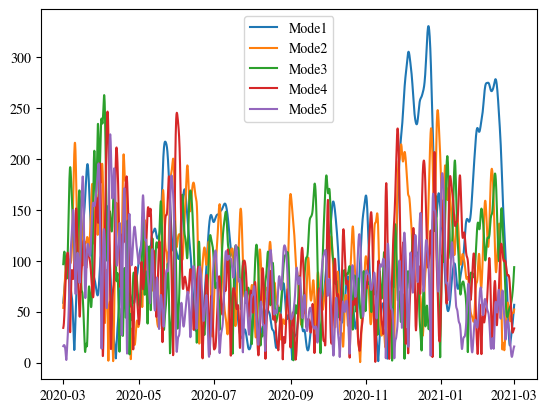

In [52]:
legends = []
for i in range(5): 
    jj = i*2 
    plt.plot(time,np.sqrt(PCs[:,jj]**2 + PCs[:,jj+1]**2),label='Mode' + str(i+1) )
    
    legends.append('Mode'+str(i+1)) 
plt.legend(legends)

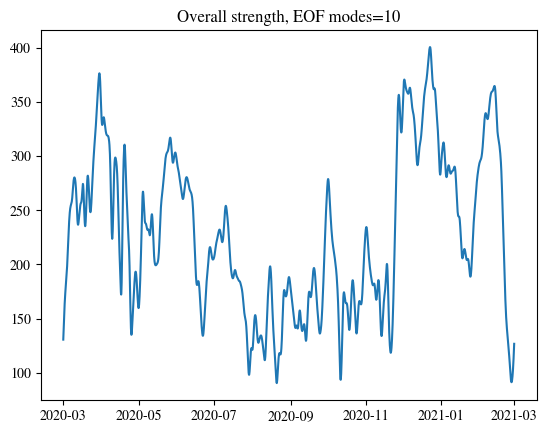

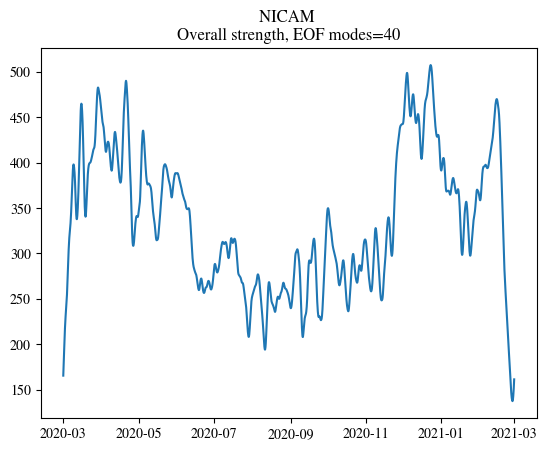

In [85]:
tmp_sum    = 0 
tmp_sum2 = 0 
for i in range(10): 
    tmp_sum = PCs[:,i]**2 + tmp_sum

for i in range(40): 
    tmp_sum2 = PCs[:,i]**2 + tmp_sum2

str_40 = tmp_sum2

plt.plot(time,np.sqrt(tmp_sum))
plt.title('Overall strength, EOF modes=10')
plt.show()

plt.plot(time,np.sqrt(tmp_sum2))
plt.title(case_str_n + 'Overall strength, EOF modes=40')
plt.savefig(figpath + case_str + 'strength40.png',dpi=300)


Text(0.5, 1.0, 'Strong event > 15 days')

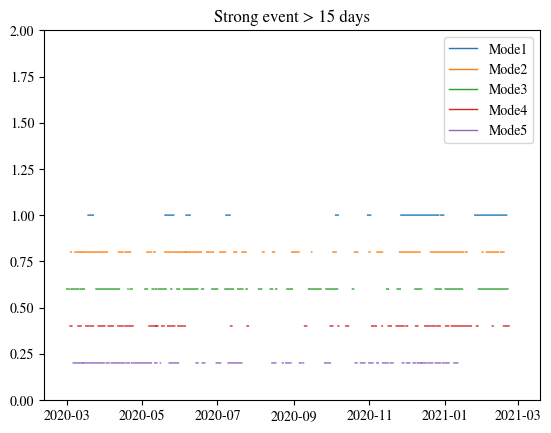

In [35]:
def fill_gap(arr,gap_threshold):
    # Step 1: find where gaps are
    is_gap = arr == 1
    
    # Step 2: identify gap runs using np.diff
    gap_starts = np.where(np.diff(np.concatenate(([0], is_gap.astype(int)))) == 1)[0]
    gap_ends = np.where(np.diff(np.concatenate((is_gap.astype(int), [0]))) == -1)[0]
    
    # Step 3: fill gaps that are smaller than the threshold
    for start, end in zip(gap_starts, gap_ends):
        if (end - start) <= gap_threshold:
            arr[start:end+1] = np.nan
    
    return arr


legends = []
for i in range(5): 
    jj = i*2
    strength                = np.sqrt(PCs[:,jj]**2 + PCs[:,jj+1]**2)
    strength_identification = np.where(strength - stds[i]*2 >0, np.ones(len(time))*(1-0.2*i) ,np.nan) 
    #plt.plot(time,np.sqrt(PCs[:,jj]**2 + PCs[:,jj+1]**2),label='Mode' + str(i+1) )
    str_id_remove = fill_gap(strength_identification,15)
    plt.plot(time,strength_identification,linewidth=1)
    legends.append('Mode'+str(i+1)) 
    
plt.ylim(0,2)
plt.legend(legends)
plt.title('Strong event > 15 days')

In [36]:
def remove_wavenumber_1(data,axis):
    # data shape: (time, 2)
    data_fft = np.fft.fft(data, axis=axis)

    if axis == 0 :
        data_fft[1] = 0
    else: 
    # Zero out wavenumber 1 (the second coefficient)
        data_fft[:, 1] = 0

    # Inverse FFT to return to physical space
    filtered = np.fft.ifft(data_fft, axis=axis).real
    return filtered

def remove_wavenumber_1_ai(data, axis):
    """
    Remove wavenumber 1 from 2D time series using FFT.
    data: shape (time, space) or (space, time)
    """
    # Compute FFT along desired axis
    data_fft = np.fft.fft(data, axis=axis)

    # Remove wavenumber 1
    if axis == 0:
        data_fft[1, :] = 0
        data_fft[-1, :] = 0  # remove negative freq
    elif axis == 1:
        data_fft[:, 1] = 0
        data_fft[:, -1] = 0  # remove negative freq

    # Return inverse FFT (real part)
    filtered = np.fft.ifft(data_fft, axis=axis).real
    filtered = filtered
    return filtered

In [60]:
def find_nearest(point,a,k):
    # a : the array contains the point
    # a : (time, points)
    # persent : nearest 
    # return : indexs
    size      = a.shape[0]
    points    = np.tile(point,(size,1))
    norm      = np.sum((points-a)**2,axis=1)
    
    top_k_idx = norm.argsort()[::1][0:k]
    return top_k_idx

def jacobian(x_0,x_1,bias):
#---modified 0403---------
    lenx = np.shape(x_0)[1]
    jaco = linalg.inv(x_0.T@x_0+bias*np.eye(lenx))@x_0.T@x_1
    return jaco


In [72]:
## How strong is the nonlinearity? for PC1 and PC2 
## Physical meaning: one circle means the one period of Kelvin wave, and the norm (how big is that circle) means the strength 
## We have to do remove linearity 
##################################################################################
data_pc12 = PCs[:,:2]

X = data_pc12[:-1]
Y = data_pc12[1:] 
jaco = jacobian(X,Y,1e-15)
print(jaco)

eigvals, eigenvectors = np.linalg.eig(jaco)
div_clim = np.sum( np.log( np.real(eigvals)  ) )
print(div_clim)    ########## the divergence of "climatology" 

time_len_div = data_pc12.shape[0]

div_pc12 = np.zeros(time_len_div) 

for i in tqdm(range(time_len_div)):
    p = data_pc12[i,:]
    
    idx = find_nearest(p,data_pc12,20)
    idx = idx[idx+1<time_len_div-1][:10]
    x_0 = data_pc12[idx,:]
    x_1 = data_pc12[idx+1,:]
    A     = np.dot(x_1.T, x_0) 
    A_inv = np.linalg.inv(A)
    jaco  = np.dot(A_inv, np.dot(x_1.T, x_1))
    
    
    eigvals, eigenvectors = np.linalg.eig(jaco)
    div_pc12[i]   = np.sum( np.log( np.real( eigvals)  ) )
    





[[ 0.99888289  0.04189311]
 [-0.04382173  0.99889672]]
-0.00222162620084896


  0%|                                                  | 0/2920 [00:00<?, ?it/s]/tmp/ipykernel_648896/3159913883.py:33: RuntimeWarning: invalid value encountered in log
  div_pc12[i]   = np.sum( np.log( np.real( eigvals)  ) )
100%|█████████████████████████████████████| 2920/2920 [00:00<00:00, 7348.13it/s]


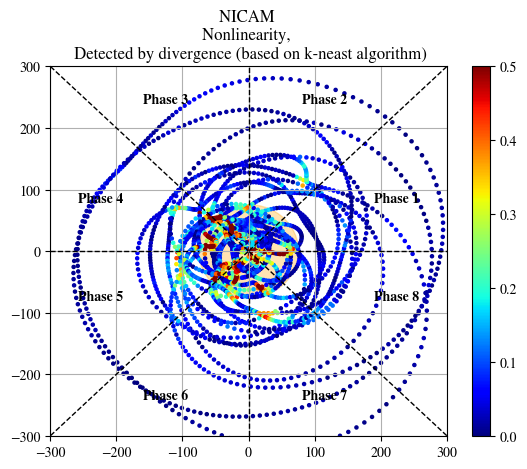

In [86]:
fig, ax = plt.subplots()

fff.plot_kw_phase_space_ax(ax,amp=300,std=stds[0])

sc = ax.scatter(PCs[:,0],PCs[:,1],s=5,c=np.abs(div_pc12),
            vmin=0,vmax=0.5,
            cmap='jet')



cbar = plt.colorbar(sc, ax=ax)
plt.title(case_str_n + 'Nonlinearity, \n Detected by divergence (based on k-neast algorithm)')

plt.savefig(figpath + case_str + 'nonlinearity.png',dpi=300)

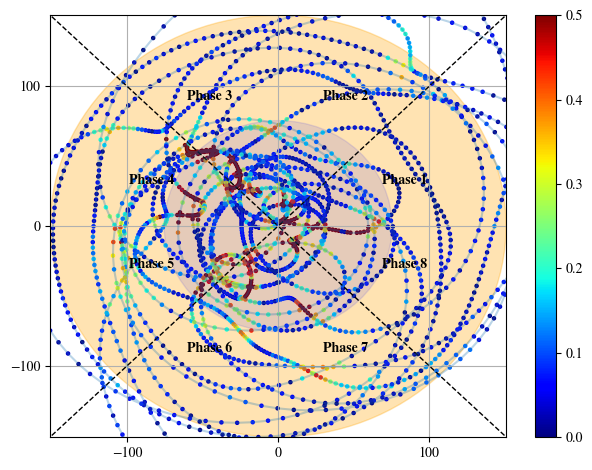

In [74]:
fig, ax = plt.subplots()
amp1_circ = plt.Circle((0, 0), stds[0], color='r',alpha=0.3, fill=True)
fff.plot_kw_phase_space_ax(ax,amp=300,std=2*stds[0],scale=30)

lines = ax.plot(PCs[:,0],PCs[:,1],alpha=0.3)
sc = ax.scatter(PCs[:,0],PCs[:,1],s=5,c=np.abs(div_pc12),
            vmin=0,vmax=0.5,
            cmap='jet')

amp1_circ = plt.Circle((0, 0), stds[0], color='blue',alpha=0.1, fill=True)
ax.add_patch(amp1_circ)

ax.set_xlim(-2*stds[0],2*stds[0])
ax.set_ylim(-2*stds[0],2*stds[0])
cbar = plt.colorbar(sc, ax=ax)
plt.tight_layout()
#plt.savefig(figpath + case_str + 'nonlinearity_close.png',dpi=300)

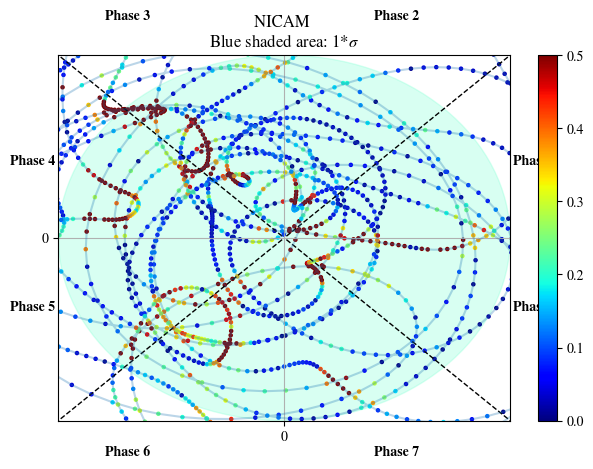

In [89]:
fig, ax = plt.subplots()

fff.plot_kw_phase_space_ax(ax,amp=300,std=stds[0],scale=30,cle_color='aquamarine')

lines = ax.plot(PCs[:,0],PCs[:,1],alpha=0.3)
sc = ax.scatter(PCs[:,0],PCs[:,1],s=5,c=np.abs(div_pc12),
            vmin=0,vmax=0.5,
            cmap='jet')


ax.set_xlim(-stds[0],stds[0])
ax.set_ylim(-stds[0],stds[0])
cbar = plt.colorbar(sc, ax=ax)
plt.tight_layout()
plt.title(case_str_n + 'Blue shaded area: 1*'+r'$\sigma$')
plt.savefig(figpath + case_str + 'nonlinearity_close.png',dpi=300)